In [1]:
# !pip install opencv-python
# !pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
# !pip install torchsummary

# TorchVision Pretrained Models and Fine-tuning <a class='tocSkip'>

In [2]:
from glob import glob

RAW_DIRPATH = './data/raw/'
img_filepaths = glob(RAW_DIRPATH + "*.jpeg")

## Face Detector

### Demo

In [3]:
import cv2
import face_detection
print(face_detection.available_detectors)
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

# BGR to RGB
im = cv2.imread(img_filepaths[0])[:, :, ::-1]

detections = detector.detect(im)

['DSFDDetector', 'RetinaNetResNet50', 'RetinaNetMobileNetV1']


/home/llorenzo/.conda/envs/msds2023-ml3-cnn/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/llorenzo/.conda/envs/msds2023-ml3-cnn/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

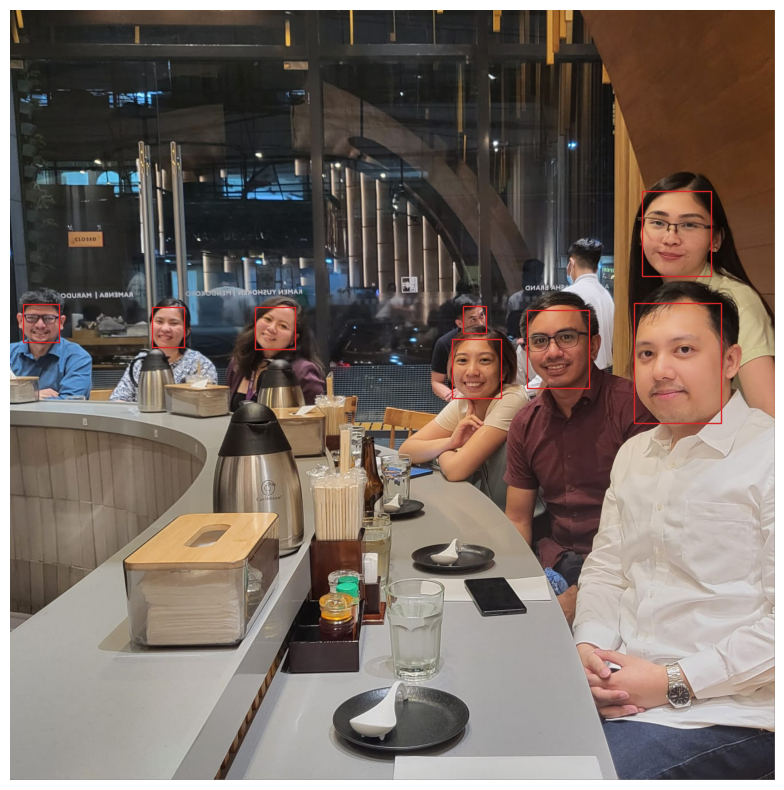

In [5]:
# Plot the bounding box of the detected face by the model
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(im)
for (x, y, x2, y2, confidence) in detections:
    rectangle = Rectangle((x, y), x2 - x, y2 - y, fill=False, ec='tab:red')
    ax.axis('off')
    ax.add_patch(rectangle)

### Pipeline

In [6]:
import os
from PIL import Image

In [7]:
OUT_DIRPATH = './data/cropped/'

os.makedirs(OUT_DIRPATH, exist_ok=True)

In [8]:
for i, img_filepath in enumerate(img_filepaths):
    im = cv2.imread(img_filepath)[:, :, ::-1]
    image = Image.open(img_filepath)
    detections = detector.detect(im)

    # Iterate on each detected faces, crop, then save the cropped image
    # onto an output directory
    for j, (x, y, x2, y2, conf) in enumerate(detections):
        cropped_image = image.crop(box=(x, y, x2, y2))
        output_filepath = os.path.join(OUT_DIRPATH, f'{i +1 :02}-{j + 1:02}.jpg')
        cropped_image.save(output_filepath)

## Data Preparation

In [9]:
import pandas as pd

In [10]:
LABELED_DIRPATH = './data/labeled/'

In [11]:
img_dirpaths = []

label_filepaths = glob(LABELED_DIRPATH + "*")
for label_filepath in label_filepaths:
    img_dirpaths.append({
        'img_dirpath': label_filepath,
        'class': label_filepath.split('.jpg')[0].split('-')[-1]
    })
img_dirpaths = pd.DataFrame(img_dirpaths)

In [12]:
classes = ['pat', 'leo', 'kann', 'rais']
img_dirpaths = img_dirpaths.loc[img_dirpaths['class'].isin(classes)]

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
df_train, df_test = train_test_split(img_dirpaths, test_size=0.20, stratify=img_dirpaths['class'])

In [15]:
import os, shutil

train_dirpath = './data/gold/train/'
test_dirpath = './data/gold/test/'

for class_name in classes:
    os.makedirs(f'{train_dirpath}/{class_name}/', exist_ok=True)
    os.makedirs(f'{test_dirpath}/{class_name}/', exist_ok=True)

In [16]:
for train_filepath, class_name in df_train.to_numpy():
    shutil.copy(train_filepath, f'{train_dirpath}/{class_name}/')
for test_filepath, class_name in df_test.to_numpy():
    shutil.copy(test_filepath, f'{test_dirpath}/{class_name}/')

In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [18]:
img_size = (64, 64)

data_transforms = transforms.Compose([
    transforms.Resize(size=img_size),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(root=train_dirpath,
                                  transform=data_transforms)
imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
means = imgs.view(3, -1).mean(dim=1).numpy()
stds = imgs.view(3, -1).std(dim=1).numpy()

print(f'Means:           {means}') 
print(f'Std. Deviations: {stds}')

Means:           [0.5992083  0.41350788 0.31791228]
Std. Deviations: [0.22938232 0.1864755  0.16624151]


In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=img_size),
        transforms.RandomHorizontalFlip(p=0.6),             
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=img_size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=img_size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
}

image_datasets = {'train': datasets.ImageFolder(train_dirpath, data_transforms['train']),
                  'validation': datasets.ImageFolder(test_dirpath, data_transforms['validation']),
                  'test': datasets.ImageFolder(test_dirpath, data_transforms['test'])}

In [20]:
batch_size = 1

dataloaders = {key: DataLoader(image_datasets[key], batch_size=batch_size, shuffle=True)
               for key in image_datasets}
dataset_sizes = {key: len(image_datasets[key]) for key in image_datasets}

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Facial Recognition Model Training

In [22]:
import torchvision
from torch import nn, optim
from torchsummary import summary

### Feature Extractor

In [23]:
model_conv = torchvision.models.vgg16(weights='IMAGENET1K_V1')
model_conv.to(device)
for param in model_conv.parameters():
    param.requires_grad = False

In [24]:
print(model_conv)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
summary(model_conv, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [26]:
model_conv.classifier = nn.Sequential(nn.Linear(512*7*7, 128),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(128, 4))
model_conv.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=0.001)

In [28]:
import copy
from time import time

In [29]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    since = time()

    # Initialize best model weights and accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Iterate through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Initialize losses and corrections
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate batch statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch statistics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Model checkpointing
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    # Print runtime and epoch summary
    time_elapsed = time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [30]:
best_model = train_model(
    model_conv, criterion, optimizer_conv, dataloaders, num_epochs=20)

Epoch 1/20
----------
train Loss: 5.5655 Acc: 0.2368
validation Loss: 2.5499 Acc: 0.5185
Epoch 2/20
----------
train Loss: 3.8476 Acc: 0.4211
validation Loss: 0.3593 Acc: 0.8148
Epoch 3/20
----------
train Loss: 0.6581 Acc: 0.7895
validation Loss: 0.2875 Acc: 0.8148
Epoch 4/20
----------
train Loss: 1.1215 Acc: 0.7368
validation Loss: 0.5395 Acc: 0.8148
Epoch 5/20
----------
train Loss: 0.9034 Acc: 0.7368
validation Loss: 0.5519 Acc: 0.8519
Epoch 6/20
----------
train Loss: 0.6459 Acc: 0.7895
validation Loss: 0.1959 Acc: 0.9259
Epoch 7/20
----------
train Loss: 0.6415 Acc: 0.8684
validation Loss: 0.1160 Acc: 0.9630
Epoch 8/20
----------
train Loss: 0.5415 Acc: 0.8158
validation Loss: 0.1070 Acc: 0.9630
Epoch 9/20
----------
train Loss: 0.2080 Acc: 0.9474
validation Loss: 0.1014 Acc: 1.0000
Epoch 10/20
----------
train Loss: 0.2046 Acc: 0.8947
validation Loss: 0.0806 Acc: 1.0000
Epoch 11/20
----------
train Loss: 0.4435 Acc: 0.8421
validation Loss: 0.1925 Acc: 0.8519
Epoch 12/20
-------

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_preds(model):
    # get batch of images from the test DataLoader  
    images, labels = next(iter(dataloaders['test']))
    images = images.to(device)
    labels = labels.to(device)

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images.cpu()))
   
    # show the real labels  
    print('Real labels: ', ' '.join('%5s' % sorted(classes)[labels[j]] 
                               for j in range(batch_size)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # show the predicted labels 
    print('Predicted: ', ' '.join('%5s' % sorted(classes)[predicted[j]] 
                              for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


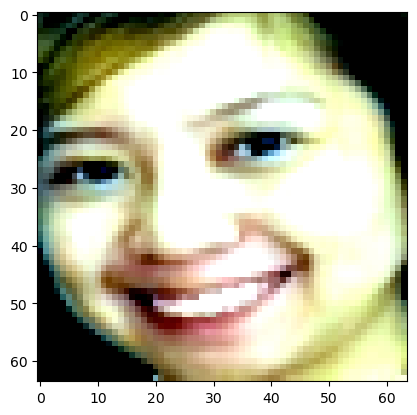

Real labels:    pat
Predicted:    pat


In [32]:
visualize_preds(best_model)

### Fine-tuning

In [42]:
model_ft = torchvision.models.vgg16(weights='IMAGENET1K_V1') 
model_ft.to(device)
for param in model_ft.parameters():
    param.requires_grad = False

In [43]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
summary(model_ft, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [45]:
model_ft.classifier = nn.Sequential(nn.Linear(512*7*7, 128),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(128, 4))
model_ft.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
# setting parameters to fine-tune
params_to_update = [# 'features.24.weight', 'features.24.bias',
                    # 'features.26.weight', 'features.26.bias',
                    'features.28.weight', 'features.28.bias',
                    'classifier.0.weight', 'classifier.0.bias',
                    'classifier.3.weight', 'classifier.3.bias',]

# store parameters in list
params = []
for name, param in model_ft.named_parameters():
    for parameters in params_to_update:        
        if parameters in name:
            param.requires_grad = True
            params.append(param)

model_ft = model_ft.to(device)

In [47]:
# The parameters of the last concolutional block and classifier are being optimized
criterion = nn.CrossEntropyLoss()
optimizer_model_ft = optim.Adam(params, lr=0.001)

In [48]:
best_model_ft = train_model(model_ft, criterion, optimizer_model_ft, dataloaders, num_epochs=20)

Epoch 1/20
----------
train Loss: 3.0579 Acc: 0.2368
validation Loss: 0.9153 Acc: 0.5556
Epoch 2/20
----------
train Loss: 1.5690 Acc: 0.4211
validation Loss: 1.0176 Acc: 0.5556
Epoch 3/20
----------
train Loss: 1.0293 Acc: 0.6053
validation Loss: 0.6289 Acc: 0.7407
Epoch 4/20
----------
train Loss: 1.0600 Acc: 0.6053
validation Loss: 0.6432 Acc: 0.8148
Epoch 5/20
----------
train Loss: 0.7382 Acc: 0.7105
validation Loss: 0.8186 Acc: 0.6296
Epoch 6/20
----------
train Loss: 0.9632 Acc: 0.7632
validation Loss: 1.2393 Acc: 0.7407
Epoch 7/20
----------
train Loss: 1.9865 Acc: 0.6316
validation Loss: 1.8566 Acc: 0.6296
Epoch 8/20
----------
train Loss: 0.7947 Acc: 0.8158
validation Loss: 0.3308 Acc: 0.8148
Epoch 9/20
----------
train Loss: 0.1132 Acc: 0.9474
validation Loss: 0.0674 Acc: 0.9630
Epoch 10/20
----------
train Loss: 1.0274 Acc: 0.8158
validation Loss: 3.4490 Acc: 0.5926
Epoch 11/20
----------
train Loss: 0.2996 Acc: 0.9737
validation Loss: 0.0850 Acc: 0.9630
Epoch 12/20
-------